In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [45]:
# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 10

In [75]:
# PARTE 1: BLACK-SCHOLES - PRICING Y GRIEGAS

def black_scholes_call(S, K, T, r, sigma):
    """
    Calcula el precio de una opción call europea usando Black-Scholes.
    
    Parámetros:
    -----------
    S : float - Precio actual del activo subyacente
    K : float - Strike price
    T : float - Tiempo a vencimiento (en años)
    r : float - Tasa libre de riesgo (anual)
    sigma : float - Volatilidad (anual)
    
    Returns:
    --------
    float - Precio teórico de la call
    """
    if T <= 0:
        return max(S - K, 0.0)
    if sigma <= 0:
        return max(S - K, 0.0)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


def calculate_greeks(S, K, T, r, sigma):
    """
    Calcula las griegas de una opción call europea.
    
    Returns:
    --------
    dict - Diccionario con Delta, Gamma, Vega, Theta y Rho
    """
    if T <= 0:
        delta = 1.0 if S > K else 0.0
        return {
            'Delta': delta,
            'Gamma': 0.0,
            'Vega': 0.0,
            'Theta': 0.0,
            'Rho': 0.0
        }
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Delta
    delta = norm.cdf(d1)
    
    # Gamma
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    
    # Vega (por 1% de cambio en volatilidad)
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100
    
    # Theta (por día)
    theta = (-(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) 
             - r * K * np.exp(-r * T) * norm.cdf(d2)) / 365
    
    # Rho (por 1% de cambio en tasa)
    rho = K * T * np.exp(-r * T) * norm.cdf(d2) / 100
    
    return {
        'Delta': delta,
        'Gamma': gamma,
        'Vega': vega,
        'Theta': theta,
        'Rho': rho
    }

In [77]:
# PARTE 2: BULL CALL SPREAD - DEFINICIÓN Y PAYOFF

class BullCallSpread:
    """
    Clase para representar una estrategia Bull Call Spread.
    
    Estructura:
    - Compra 1 call en strike K1 (lower strike)
    - Vende 1 call en strike K2 (higher strike), donde K2 > K1
    """
    
    def __init__(self, S0, K_long, K_short, T, r, sigma):
        """
        Inicializa el Bull Call Spread.
        
        Parámetros:
        -----------
        S0 : float - Precio actual del subyacente
        K_long : float - Strike de la call comprada (lower)
        K_short : float - Strike de la call vendida (higher)
        T : float - Tiempo a vencimiento (años)
        r : float - Tasa libre de riesgo
        sigma : float - Volatilidad implícita
        """
        self.S0 = S0
        self.K_long = K_long
        self.K_short = K_short
        self.T = T
        self.r = r
        self.sigma = sigma
        
        # Calcular primas usando Black-Scholes
        self.premium_long = black_scholes_call(S0, K_long, T, r, sigma)
        self.premium_short = black_scholes_call(S0, K_short, T, r, sigma)
        
        # Costo neto de la estrategia (débito)
        self.net_cost = self.premium_long - self.premium_short
        
        # Ganancia máxima y pérdida máxima
        self.max_profit = (K_short - K_long) - self.net_cost
        self.max_loss = self.net_cost
        
        # Punto de equilibrio (breakeven)
        self.breakeven = K_long + self.net_cost
        
    def payoff(self, ST):
        """
        Calcula el payoff al vencimiento para un precio ST.
        
        Parámetros:
        -----------
        ST : float o array - Precio del subyacente al vencimiento
        
        Returns:
        --------
        float o array - Payoff neto de la estrategia
        """
        ST = np.array(ST)
        
        # Payoff de la call comprada (long)
        payoff_long = np.maximum(ST - self.K_long, 0) - self.premium_long
        
        # Payoff de la call vendida (short)
        payoff_short = -(np.maximum(ST - self.K_short, 0) - self.premium_short)
        
        # Payoff total
        total_payoff = payoff_long + payoff_short
        
        return total_payoff
    
    def calculate_spread_greeks(self):
        """
        Calcula las griegas de la estrategia completa (spread).
        """
        greeks_long = calculate_greeks(self.S0, self.K_long, self.T, self.r, self.sigma)
        greeks_short = calculate_greeks(self.S0, self.K_short, self.T, self.r, self.sigma)
        
        spread_greeks = {}
        for key in greeks_long.keys():
            spread_greeks[key] = greeks_long[key] - greeks_short[key]
        
        return spread_greeks
    
    def summary(self):
        """
        Imprime un resumen de la estrategia.
        """
        print("="*70)
        print("BULL CALL SPREAD - RESUMEN DE LA ESTRATEGIA")
        print("="*70)
        print(f"\nPARÁMETROS INICIALES:")
        print(f"   Precio actual (S0): ${self.S0:.2f}")
        print(f"   Strike call comprada (K_long): ${self.K_long:.2f}")
        print(f"   Strike call vendida (K_short): ${self.K_short:.2f}")
        print(f"   Tiempo a vencimiento: {self.T:.4f} años ({self.T*365:.0f} días)")
        print(f"   Volatilidad: {self.sigma*100:.2f}%")
        print(f"   Tasa libre de riesgo: {self.r*100:.2f}%")
        
        print(f"\nPRIMAS (Black-Scholes):")
        print(f"   Prima call comprada: ${self.premium_long:.2f}")
        print(f"   Prima call vendida: ${self.premium_short:.2f}")
        print(f"   Costo neto (débito): ${self.net_cost:.2f}")
        
        print(f"\nANÁLISIS DE RIESGO/RETORNO:")
        print(f"   Ganancia máxima: ${self.max_profit:.2f}")
        print(f"   Pérdida máxima: ${self.max_loss:.2f}")
        print(f"   Ratio Riesgo/Retorno: {self.max_profit/self.max_loss:.2f}")
        print(f"   Breakeven: ${self.breakeven:.2f}")
        print(f"   ROI máximo: {(self.max_profit/self.max_loss)*100:.2f}%")
        
        print(f"\nGRIEGAS DEL SPREAD:")
        greeks = self.calculate_spread_greeks()
        for greek, value in greeks.items():
            print(f"   {greek}: {value:.4f}")
        print("="*70)



In [79]:
# PARTE 3: VOLATILIDAD HISTÓRICA

def calculate_historical_volatility(prices, window=30):
    """
    Calcula la volatilidad histórica anualizada.
    
    Parámetros:
    -----------
    prices : Series - Serie de precios
    window : int - Ventana de días para calcular
    
    Returns:
    --------
    float - Volatilidad anualizada
    """
    log_returns = np.log(prices / prices.shift(1))
    volatility = log_returns.rolling(window=window).std() * np.sqrt(252)
    return volatility

In [81]:
# PARTE 4: SIMULACIÓN MONTE CARLO

def monte_carlo_simulation(S0, mu, sigma, T, n_simulations=10000, seed=42):
    """
    Simula precios futuros usando Geometric Brownian Motion (GBM).
    
    Parámetros:
    -----------
    S0 : float - Precio inicial
    mu : float - Drift (tasa de retorno esperada)
    sigma : float - Volatilidad
    T : float - Tiempo (en años)
    n_simulations : int - Número de simulaciones
    seed : int - Semilla para reproducibilidad
    
    Returns:
    --------
    array - Precios simulados al tiempo T
    """
    np.random.seed(seed)
    
    # GBM: S_T = S_0 * exp((mu - 0.5*sigma^2)*T + sigma*sqrt(T)*Z)
    Z = np.random.standard_normal(n_simulations)
    ST = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    return ST


def monte_carlo_with_antithetic(S0, mu, sigma, T, n_simulations=10000, seed=42):
    """
    Simulación Monte Carlo con variables antitéticas para reducir varianza.
    """
    np.random.seed(seed)
    
    # Generar la mitad de simulaciones
    n_half = n_simulations // 2
    Z = np.random.standard_normal(n_half)
    
    # Variables antitéticas: usar Z y -Z
    Z_combined = np.concatenate([Z, -Z])
    
    ST = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_combined)
    
    return ST


In [83]:
# PARTE 5: VISUALIZACIONES

def plot_payoff_diagram(spread, save_path=None):
    """
    Grafica el diagrama de payoff de la estrategia.
    """
    # Rango de precios
    S_range = np.linspace(spread.S0 * 0.7, spread.S0 * 1.3, 200)
    payoffs = spread.payoff(S_range)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Payoff total
    ax.plot(S_range, payoffs, 'b-', linewidth=2.5, label='Bull Call Spread Payoff')
    
    # Líneas de referencia
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.axvline(x=spread.S0, color='green', linestyle='--', linewidth=1.5, 
               label=f'Precio Actual (${spread.S0:.2f})')
    ax.axvline(x=spread.K_long, color='orange', linestyle='--', linewidth=1.5,
               label=f'Strike Long (${spread.K_long:.2f})')
    ax.axvline(x=spread.K_short, color='red', linestyle='--', linewidth=1.5,
               label=f'Strike Short (${spread.K_short:.2f})')
    ax.axvline(x=spread.breakeven, color='purple', linestyle=':', linewidth=2,
               label=f'Breakeven (${spread.breakeven:.2f})')
    
    # Áreas de ganancia/pérdida
    ax.fill_between(S_range, payoffs, 0, where=(payoffs > 0), 
                     alpha=0.3, color='green', label='Zona de Ganancia')
    ax.fill_between(S_range, payoffs, 0, where=(payoffs < 0), 
                     alpha=0.3, color='red', label='Zona de Pérdida')
    
    ax.set_xlabel('Precio del Subyacente al Vencimiento ($)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Ganancia/Pérdida ($)', fontsize=12, fontweight='bold')
    ax.set_title('Diagrama de Payoff - Bull Call Spread', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_monte_carlo_results(spread, ST_simulated, save_path=None):
    """
    Visualiza los resultados de la simulación Monte Carlo.
    """
    payoffs = spread.payoff(ST_simulated)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Distribución de precios simulados
    axes[0, 0].hist(ST_simulated, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(spread.S0, color='red', linestyle='--', linewidth=2, 
                       label=f'S0 = ${spread.S0:.2f}')
    axes[0, 0].axvline(np.mean(ST_simulated), color='green', linestyle='--', linewidth=2,
                       label=f'Media = ${np.mean(ST_simulated):.2f}')
    axes[0, 0].set_xlabel('Precio Simulado ($)', fontweight='bold')
    axes[0, 0].set_ylabel('Frecuencia', fontweight='bold')
    axes[0, 0].set_title('Distribución de Precios Simulados (ST)', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Distribución de payoffs
    axes[0, 1].hist(payoffs, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].axvline(0, color='black', linestyle='-', linewidth=1)
    axes[0, 1].axvline(np.mean(payoffs), color='blue', linestyle='--', linewidth=2,
                       label=f'EV = ${np.mean(payoffs):.2f}')
    axes[0, 1].set_xlabel('Payoff ($)', fontweight='bold')
    axes[0, 1].set_ylabel('Frecuencia', fontweight='bold')
    axes[0, 1].set_title('Distribución de Payoffs', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Análisis de probabilidades
    prob_profit = (payoffs > 0).mean()
    prob_loss = (payoffs < 0).mean()
    prob_max_profit = (payoffs >= spread.max_profit * 0.9).mean()
    prob_max_loss = (payoffs <= -spread.max_loss * 0.9).mean()
    
    categories = ['Ganancia', 'Pérdida', 'Ganancia\nMáxima', 'Pérdida\nMáxima']
    probabilities = [prob_profit, prob_loss, prob_max_profit, prob_max_loss]
    colors = ['green', 'red', 'darkgreen', 'darkred']
    
    axes[1, 0].bar(categories, probabilities, color=colors, alpha=0.7, edgecolor='black')
    axes[1, 0].set_ylabel('Probabilidad', fontweight='bold')
    axes[1, 0].set_title('Análisis de Probabilidades', fontweight='bold')
    axes[1, 0].set_ylim(0, 1)
    for i, v in enumerate(probabilities):
        axes[1, 0].text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Estadísticas
    axes[1, 1].axis('off')
    stats_text = f"""
    ESTADÍSTICAS DE LA SIMULACIÓN
    {'='*40}
    
    Precio Esperado (E[ST]):  ${np.mean(ST_simulated):.2f}
    Desv. Est. de ST:         ${np.std(ST_simulated):.2f}
    
    Payoff Esperado (EV):     ${np.mean(payoffs):.2f}
    Mediana de Payoff:        ${np.median(payoffs):.2f}
    Desv. Est. de Payoff:     ${np.std(payoffs):.2f}
    
    Probabilidad de Ganancia: {prob_profit*100:.2f}%
    Probabilidad de Pérdida:  {prob_loss*100:.2f}%
    
    Ganancia Promedio:        ${np.mean(payoffs[payoffs > 0]):.2f}
    Pérdida Promedio:         ${np.mean(payoffs[payoffs < 0]):.2f}
    
    VaR 95%:                  ${np.percentile(payoffs, 5):.2f}
    CVaR 95%:                 ${np.mean(payoffs[payoffs <= np.percentile(payoffs, 5)]):.2f}
    """
    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_greeks_sensitivity(spread, save_path=None):
    """
    Analiza la sensibilidad de las griegas.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Análisis de Sensibilidad - Griegas del Bull Call Spread', 
                 fontsize=14, fontweight='bold')
    
    # Rangos de variación
    S_range = np.linspace(spread.S0 * 0.8, spread.S0 * 1.2, 50)
    T_range = np.linspace(0.01, spread.T * 2, 50)
    sigma_range = np.linspace(spread.sigma * 0.5, spread.sigma * 1.5, 50)
    
    # 1. Delta vs Precio
    deltas = []
    for S in S_range:
        temp_spread = BullCallSpread(S, spread.K_long, spread.K_short, 
                                     spread.T, spread.r, spread.sigma)
        greeks = temp_spread.calculate_spread_greeks()
        deltas.append(greeks['Delta'])
    
    axes[0, 0].plot(S_range, deltas, 'b-', linewidth=2)
    axes[0, 0].axvline(spread.S0, color='r', linestyle='--', label='S0')
    axes[0, 0].set_xlabel('Precio del Subyacente ($)')
    axes[0, 0].set_ylabel('Delta')
    axes[0, 0].set_title('Delta vs Precio')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Gamma vs Precio
    gammas = []
    for S in S_range:
        temp_spread = BullCallSpread(S, spread.K_long, spread.K_short,
                                     spread.T, spread.r, spread.sigma)
        greeks = temp_spread.calculate_spread_greeks()
        gammas.append(greeks['Gamma'])
    
    axes[0, 1].plot(S_range, gammas, 'g-', linewidth=2)
    axes[0, 1].axvline(spread.S0, color='r', linestyle='--', label='S0')
    axes[0, 1].set_xlabel('Precio del Subyacente ($)')
    axes[0, 1].set_ylabel('Gamma')
    axes[0, 1].set_title('Gamma vs Precio')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Vega vs Volatilidad
    vegas = []
    for sigma in sigma_range:
        temp_spread = BullCallSpread(spread.S0, spread.K_long, spread.K_short,
                                     spread.T, spread.r, sigma)
        greeks = temp_spread.calculate_spread_greeks()
        vegas.append(greeks['Vega'])
    
    axes[0, 2].plot(sigma_range * 100, vegas, 'purple', linewidth=2)
    axes[0, 2].axvline(spread.sigma * 100, color='r', linestyle='--', label='σ actual')
    axes[0, 2].set_xlabel('Volatilidad (%)')
    axes[0, 2].set_ylabel('Vega')
    axes[0, 2].set_title('Vega vs Volatilidad')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Theta vs Tiempo
    thetas = []
    for T in T_range:
        temp_spread = BullCallSpread(spread.S0, spread.K_long, spread.K_short,
                                     T, spread.r, spread.sigma)
        greeks = temp_spread.calculate_spread_greeks()
        thetas.append(greeks['Theta'])
    
    axes[1, 0].plot(T_range * 365, thetas, 'orange', linewidth=2)
    axes[1, 0].axvline(spread.T * 365, color='r', linestyle='--', label='T actual')
    axes[1, 0].set_xlabel('Días hasta Vencimiento')
    axes[1, 0].set_ylabel('Theta')
    axes[1, 0].set_title('Theta vs Tiempo')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Precio del Spread vs Precio del Subyacente
    spread_values = []
    for S in S_range:
        temp_spread = BullCallSpread(S, spread.K_long, spread.K_short,
                                     spread.T, spread.r, spread.sigma)
        spread_values.append(temp_spread.net_cost)
    
    axes[1, 1].plot(S_range, spread_values, 'brown', linewidth=2)
    axes[1, 1].axvline(spread.S0, color='r', linestyle='--', label='S0')
    axes[1, 1].axhline(spread.net_cost, color='b', linestyle='--', label='Costo actual')
    axes[1, 1].set_xlabel('Precio del Subyacente ($)')
    axes[1, 1].set_ylabel('Valor del Spread ($)')
    axes[1, 1].set_title('Valor del Spread vs Precio')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Tabla de griegas actuales
    axes[1, 2].axis('off')
    greeks_current = spread.calculate_spread_greeks()
    greeks_text = "GRIEGAS ACTUALES\n" + "="*25 + "\n\n"
    for greek, value in greeks_current.items():
        greeks_text += f"{greek:8s}: {value:8.4f}\n"
    
    axes[1, 2].text(0.1, 0.5, greeks_text, fontsize=12, family='monospace',
                    verticalalignment='center')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()




ANÁLISIS DE ESTRATEGIA: BULL CALL SPREAD

✓ Precio actual: $902.68
✓ Volatilidad histórica (30d): 37.00%

BULL CALL SPREAD - RESUMEN DE LA ESTRATEGIA

PARÁMETROS INICIALES:
   Precio actual (S0): $902.68
   Strike call comprada (K_long): $902.68
   Strike call vendida (K_short): $947.81
   Tiempo a vencimiento: 0.0822 años (30 días)
   Volatilidad: 37.00%
   Tasa libre de riesgo: 4.00%

PRIMAS (Black-Scholes):
   Prima call comprada: $39.62
   Prima call vendida: $21.59
   Costo neto (débito): $18.02

ANÁLISIS DE RIESGO/RETORNO:
   Ganancia máxima: $27.11
   Pérdida máxima: $18.02
   Ratio Riesgo/Retorno: 1.50
   Breakeven: $920.70
   ROI máximo: 150.42%

GRIEGAS DEL SPREAD:
   Delta: 0.1800
   Gamma: 0.0003
   Vega: 0.0668
   Theta: -0.0570
   Rho: 0.1187

Generando diagrama de payoff...


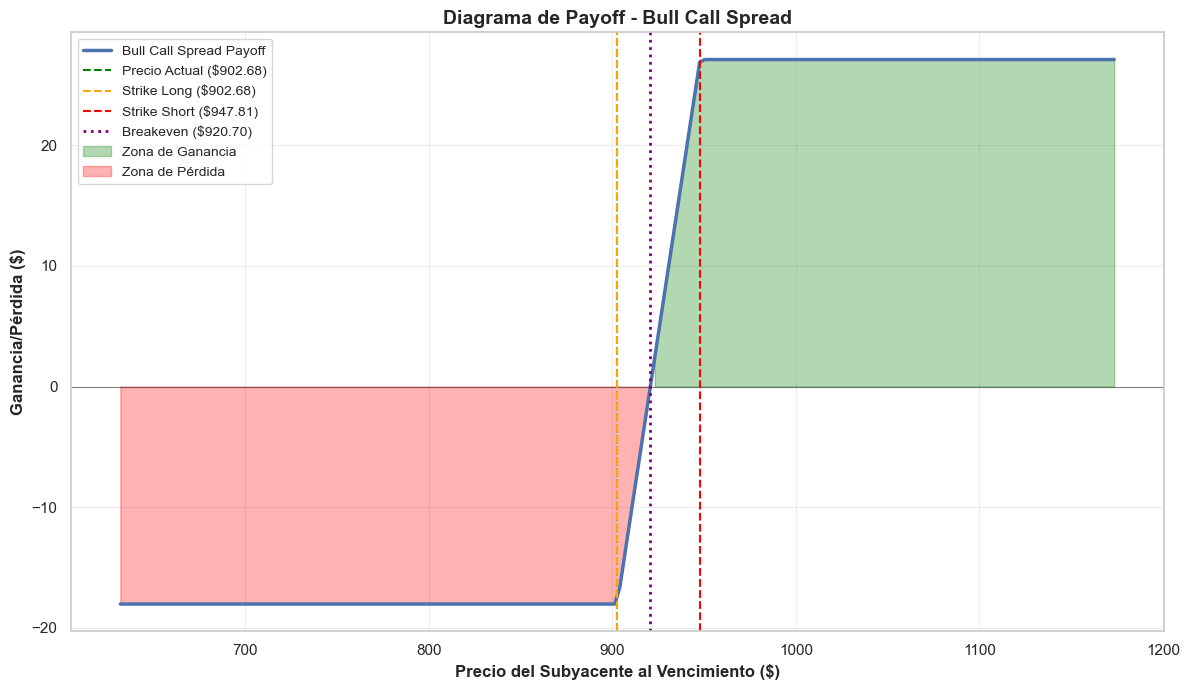


Ejecutando simulación Monte Carlo...
✓ 50000 simulaciones completadas


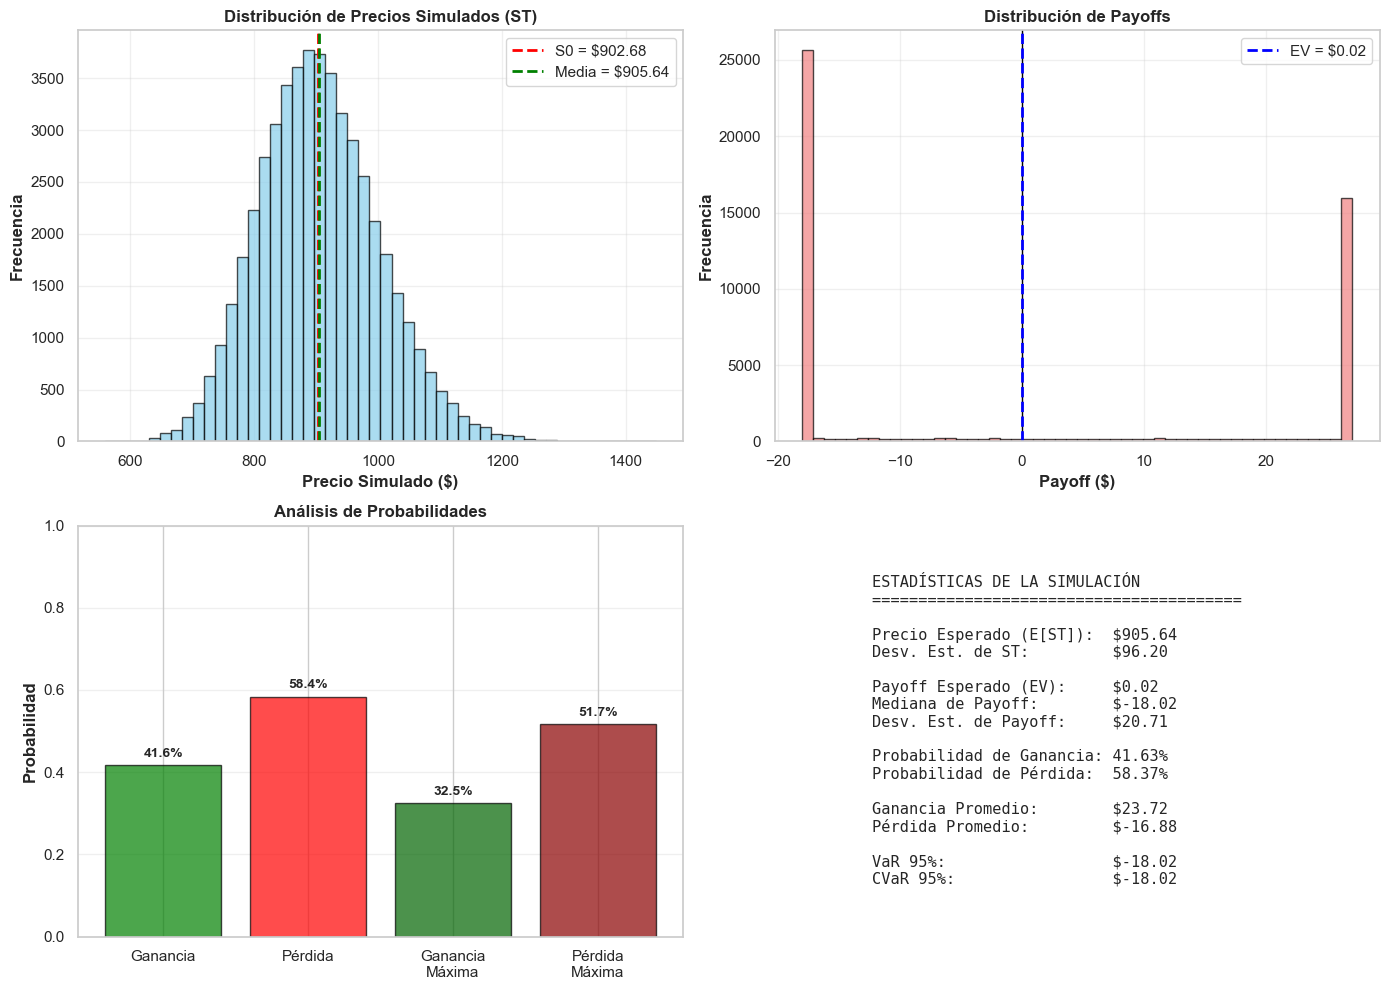


Analizando sensibilidad (Griegas)...


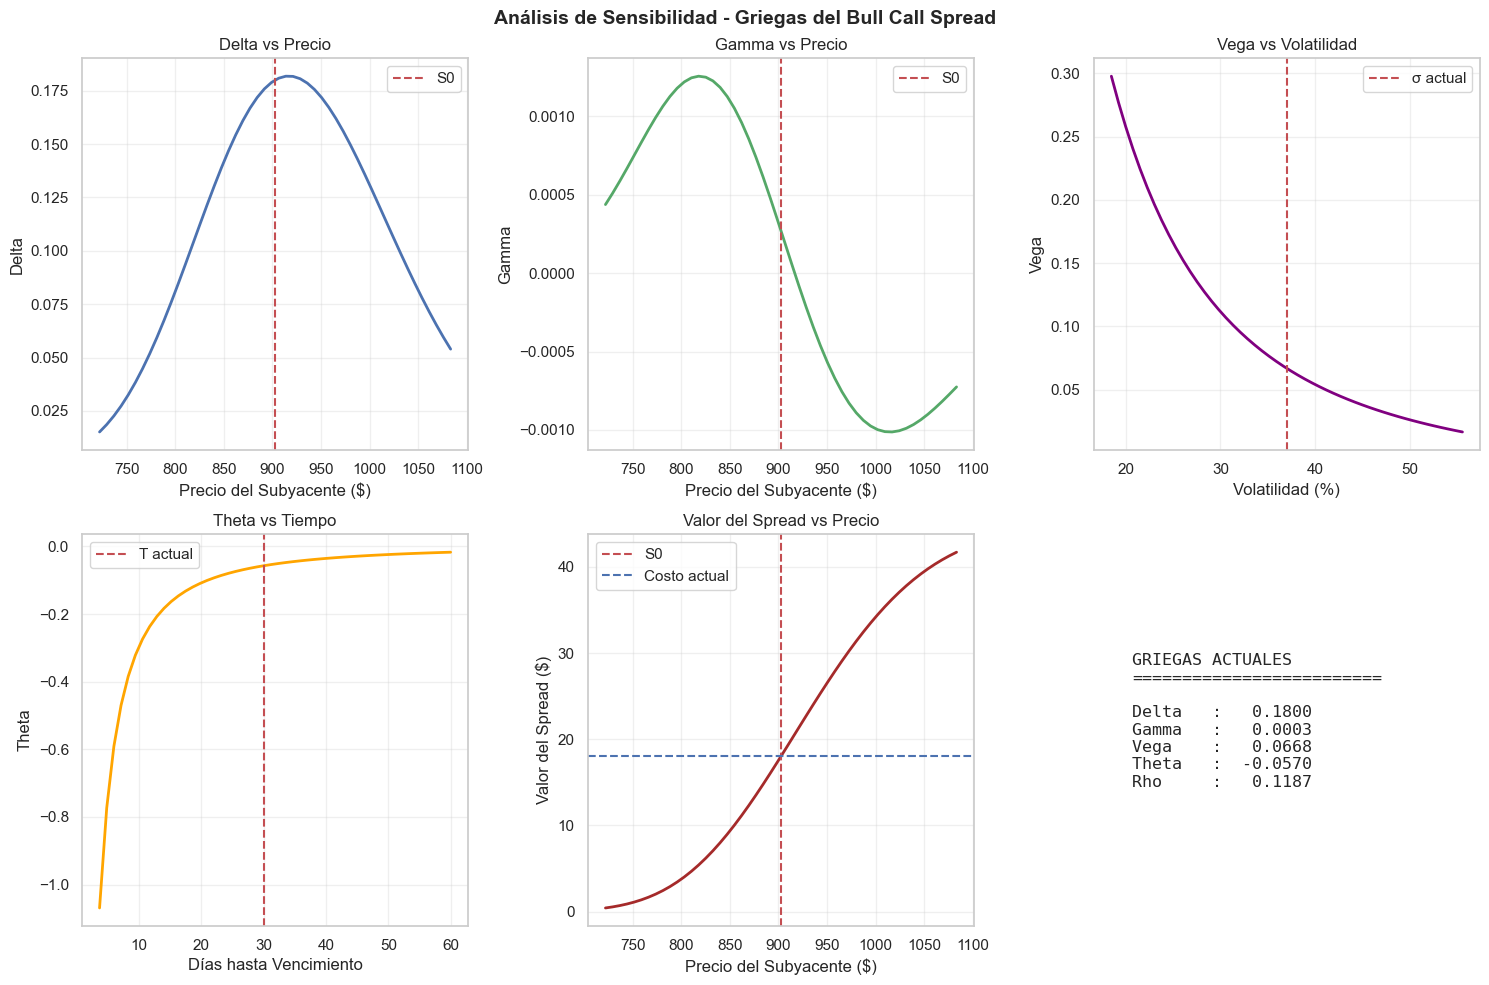

In [99]:
# PARTE 6: EJEMPLO DE USO

if __name__ == "__main__":
    print("\n" + "="*70)
    print("ANÁLISIS DE ESTRATEGIA: BULL CALL SPREAD")
    print("="*70 + "\n")
    
    # Paso 1: Descargar datos del activo
    ticker = "LLY"  # Cambiar según preferencia
    
    data = yf.download(ticker, period="1y", progress=False)
    
    # Convertir a float para evitar errores
    S0 = float(data['Close'].iloc[-1])
    
    # Calcular volatilidad histórica
    hist_vol = float(calculate_historical_volatility(data['Close'], window=30).iloc[-1])
    
    print(f"✓ Precio actual: ${S0:.2f}")
    print(f"✓ Volatilidad histórica (30d): {hist_vol*100:.2f}%\n")
    
    # Paso 2: Definir parámetros de la estrategia
    K_long = S0 * 1.00    # ATM (at-the-money)
    K_short = S0 * 1.05   # 5% OTM (out-of-the-money)
    T = 30 / 365          # 30 días
    r = 0.04              # Tasa libre de riesgo 4%
    sigma = hist_vol      # Usar volatilidad histórica
    
    # Paso 3: Crear el spread
    spread = BullCallSpread(S0, K_long, K_short, T, r, sigma)
    spread.summary()
    
    # Paso 4: Visualizar payoff
    print("\nGenerando diagrama de payoff...")
    plot_payoff_diagram(spread)
    
    # Paso 5: Simulación Monte Carlo
    print("\nEjecutando simulación Monte Carlo...")
    n_sims = 50000
    ST_simulated = monte_carlo_with_antithetic(S0, r, sigma, T, n_sims)
    
    print(f"✓ {n_sims} simulaciones completadas")
    plot_monte_carlo_results(spread, ST_simulated)
    
    # Paso 6: Análisis de griegas
    print("\nAnalizando sensibilidad (Griegas)...")
    plot_greeks_sensitivity(spread)